# Görüntü İşleme İle Trafik Levhası Tespiti
### - Bu projede görüntü işleme teknikleri kullanılarak farklı tabelalar birbirinden ayırt edilmeye açlışılmıştır.
### - Elimde veriseti olmadığı için görüntüler ve tabelalarda birbirinden ayrıştırıcı unsurlar(öznitelikler) ortaya çıkarılarak tespit, sınıflandırma sağlanmıştır.
### - Sınıflandırma sağlanması için tabela rengi, tabeladaki noktaların birbirine göre durumu, yuvarlaklık özellikleri kullanılmıştır.
#### Öncelikle kütüphaneleri tanımlayıp, görüntüleri bir liste içinde tutalım.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os
image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

### - Levhaların yuvarlaklığını ölçen bir fonksiyon. 
### - "Yolyok" tabelasında yuvarlaklık olmadığı için kolayca diğerlerinden ayrıştırılmıştır.
### - "10KM" tabelası diğer tabelalara göre farklı boyutlarda olduğu için yarıçapı ve çember üzerindeki noktaları diğer görüntülere göre daha büyük olduğundan ayrıştırılmıştır
### - "Sağa Dön", "Düz Git" ve "Stop" tabelaları benzer yuvarlaklık ve yarıçapa sahip olduğundan bu aşamada sınıflandırılmamışlardır.
### - Ayrıca algılanan tabelaların etrafına çember çizilmiş, çemberin orta noktası ve yarıçapı verileri döndürülmüştür.

In [2]:
def checkCircularity(image,colored_image):
    """
    - Yuvarlaklık test eder.
    - "Yol yok" tabelasında yuvarlaklık olmadığından kolayca ayrıştırır.
    - "10Km" tabelasındaki yuvarlaklığın yarıçapı çok daha büyük olduğundan dolayı ayrıştırır.
    - "10km","yolyok","Digerleri" olmak üzere bilgi döndürür. 
    - "Digerleri": "Sağa Dön","Stop","Düz Git" tabelaları
    - Ayrıca çember çizilmiş görsel ve çemberin orta noktaları döndürür
    """
    signs = ["10","Digerleri","Yolyok"]
    returned_value = None
    points = None
    # Çemberi bulan method
    circles_sign_1 = cv2.HoughCircles(image,cv2.HOUGH_GRADIENT,1,20,
                            param1=100,param2=30,minRadius=450,maxRadius=452)
    if circles_sign_1 is not None:
        returned_value = signs[0]
        circles_sign_1 = np.uint16(np.around(circles_sign_1))
        for i in circles_sign_1[0,:]:
            # Dış Çember
            cv2.circle(colored_image,(i[0],i[1]),i[2],(0,255,0),2)
            # Orta Nokta
            cv2.circle(colored_image,(i[0],i[1]),2,(0,0,255),3)
            # Noktalar tutulur
            points = [i[0],i[1],i[2]]
        del circles_sign_1
    
    circles_sign_2 = cv2.HoughCircles(image,cv2.HOUGH_GRADIENT,1,20,
                            param1=100,param2=30,minRadius=187,maxRadius=192)
    if circles_sign_2 is not None:
        returned_value = signs[1]
        circles_sign_2 = np.uint16(np.around(circles_sign_2))
        for i in circles_sign_2[0,:]:
            # Dış Çember
            cv2.circle(colored_image,(i[0],i[1]),i[2],(0,255,0),2)
            # Orta Nokta
            cv2.circle(colored_image,(i[0],i[1]),2,(0,0,255),3)
            # Noktalar tutulur
            points = [i[0],i[1],i[2]]
        del circles_sign_1
    
    if returned_value == None:
        # Eğer çember yok ise "Yolyok" tabelasıdır.
        returned_value = signs[2]
    return returned_value,colored_image,points

### - Bu fonksiyon sayesinde tabelaların renkleri sınıflandırlabilmektedir.
### - "10KM" ve "STOP" tabelası kırmızıdır. "Sağa Dön" ve "Düz Git" tabelaları mavidir. "Yol Yok" tabelası ise siyah beyaz olduğundan dolayı üç farklı sınıfa ayrıştırılmıştır.

In [3]:
def checkColours(image):
    """
    - Tabelanın kırmızı mı mavi mi içerdiğini hesaplayan bir fonksiyon
    - HSV uzayına çekip filtreler
    - Görselin hangi renkte olduğuna döndürür.
    """
    returned_value = None

    image_ = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Kırmızı birinci threshold; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    
    # Kırmızı ikinci threshold; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])
    
    lower_mask = cv2.inRange(image_, lower1, upper1)
    upper_mask = cv2.inRange(image_, lower2, upper2)
    
    full_mask = lower_mask + upper_mask;
    # Kırmızılık kontrolü
    result_red = cv2.bitwise_and(image_, image_, mask=full_mask)
    result_red[np.where(full_mask==0)] = 0
    result_red = cv2.cvtColor(result_red,cv2.COLOR_BGR2GRAY).flatten().sum()
    if result_red > 5000000:
        returned_value = "Kirmizi"

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
     
    # Mavi Filtre
    lower_blue = np.array([60, 35, 140])
    upper_blue = np.array([180, 255, 255])
 
    # Mavi MAske
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
     
    # MAvilik kontrolü
    result_blue = cv2.bitwise_and(hsv, hsv, mask=mask)
    result_blue[np.where(mask==0)] = 0
    result_blue = cv2.cvtColor(result_blue,cv2.COLOR_BGR2GRAY).flatten().sum()
    if result_blue > 5000000:
        returned_value = "Mavi"
    
    if returned_value is None:
        returned_value = 'RenksizYolyok'
    return returned_value

## - MAvi renkte olan "Sağa Dön" ve "Düz Git" tabelalarını sınıflandırmak için tasarlanmıştır. 
## - CannyHarris ile oklardaki köşeler algılanmıştır.
## - Köşe noktaları arasındaki farka bakılarak "Düz" ve "Sağa git" işaretleri ayrıştırılmıştır.

In [4]:
def checkRightOrStraight(image):
    """
    - Tabelanın sağa dönüş mü düz git mi olduğunu ayrıştırır
    - CannyHarris ile corner noktaları çıkartılır.
    - "Sağa dönüş" noktasına ait ilk iki nokta ona ait bir özellik olduğundan dolayı "Düz Git" tabelasından ayrıştırır.
    - Yön bilgisi döndürür.
    """
    returned_value = None
    gray = np.float32(image)
    dst = cv2.cornerHarris(gray,5,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    if int(corners[1][1]) == int(corners[2][1]):
        returned_value = 'Saga'
    else:
        returned_value = 'Duz'
    return returned_value

### - Çember orta noktası ve yarıçapı kullanılarak çember üsütne yazı yazılacak yeri hesaplayan bir fonksiyon

In [5]:
def pointComputer(points):
    """
    - Çember Orta noktası ile yazı yazılan bölgeyi hesaplayan bir fonksiyon.
    """
    if points is not None:
        points[1] = int(points[1]-(points[2]-20))
        points[0] = int(points[0])
        points = tuple(points[:2])
    else:
        height, width = img.shape[:2]
        center_y = int(height/2)
        center_x = int(width/2)
        points = (center_x-60,center_y-230)
    return points

### Görüntü dizinlerini görselleştirelim.

In [6]:
image_paths

['/kaggle/input/deneme-trafik/1.jpg',
 '/kaggle/input/deneme-trafik/4.jpg',
 '/kaggle/input/deneme-trafik/3.jpg',
 '/kaggle/input/deneme-trafik/yolyok.png',
 '/kaggle/input/deneme-trafik/2.jpg']

### - Öncelikle görselleştirme için matplotlib figürü tanımlanmıştır.
### - Görüntü dizinleri olan liste for döngüsü kullanılarak döndürülmüş sırasıyla aşağıdaki işlemler gerçekleştirilmiştir:
#### 1 - Görüntü Okunur
#### 2 - Görüntü önce gri skalaya çekilip daha sonra blurlanır. Yuvarlaklığı algılamamızı sağlayan "hough transform" methodu bu şekilde input almaktadır.
#### 3 - Yuvarlaklık test edilir. Çıktılar "sign", çıktı görseller "colored_image", noktalar ise "points" değişkeninde tutulmaktadır.
#### 4 - Devamında renk testi uygulanır. Renk testi çıktısı "renk" değişkeninde tutulur.
#### 5 - Bu aşamada "Düz" ve "Sağa Dön" testi yapılır. Çıktılar "yon" değişkeninde tutulur
#### 6 - Yuvarlaklık testinde ortaya çıkan çember verileri, resim üzerine yazı yazmak için çember üst noktası hesaplanır.
#### 7 - Devamında koşul yapısı kullanılarak farklı görüntüler sınıflandırılır. Her bir görüntü figür üzerine görselleştirilir.

Dairesellik:  10
REnk : Mavi
10KM TABELASI
Dairesellik:  Digerleri
REnk : Kirmizi
STOP TABELASI
Dairesellik:  Digerleri
REnk : Mavi
DUZ GİT TABELASI
Dairesellik:  Yolyok
REnk : RenksizYolyok
YOL YOK TABELASI
Dairesellik:  Digerleri
REnk : Mavi
SAGA DON TABELASI


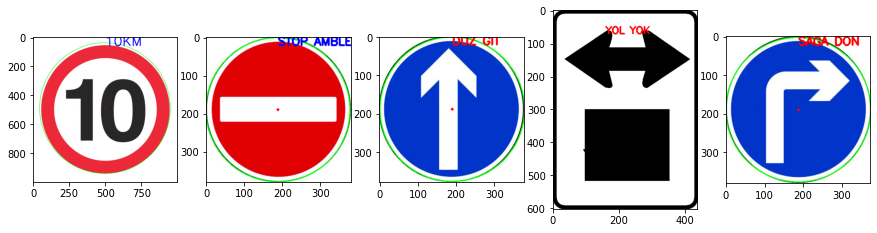

In [7]:
f = plt.figure(figsize=(15,15))
for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])  # Görüntü Okunur
    g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Görüntü gri skalaya çekilir
    img_b = cv2.medianBlur(g_img,5) # Görüntü blurlanır.
    colored_image = img.copy()
    sign,colored_image,points = checkCircularity(img_b,colored_image) # Çemberlik bulur
    print('Dairesellik: ',sign)
    renk = checkColours(img) # Renk bulur
    print('REnk :',renk)
    yon = checkRightOrStraight(g_img) # Sağ mı düz mü tabela bulur
    points = pointComputer(points) # Nokta hesaplar
    # Bu bölgede çıkardığımız öznitelikler birleşitirerek koşul yapısılya sınıflandırılır.
    if sign == "10" :
        print('10KM TABELASI')
        cv2.putText(colored_image, '10KM', points, cv2.FONT_ITALIC, 3, (255, 0, 0), 5)
    elif sign == "Digerleri" and renk =="Kirmizi":
        print("STOP TABELASI")
        cv2.putText(colored_image, 'STOP AMBLEMİ', points, cv2.FONT_ITALIC, 1, (255, 0, 0), 3)
    elif sign == "Digerleri" and renk == "Mavi" and yon == "Saga":
        print('SAGA DON TABELASI')
        cv2.putText(colored_image, 'SAGA DON', points, cv2.FONT_ITALIC, 1, (0, 0, 255), 3)
    elif sign == "Digerleri" and renk == "Mavi" and yon == "Duz":
        print('DUZ GİT TABELASI')
        cv2.putText(colored_image, 'DUZ GIT', points, cv2.FONT_ITALIC, 1, (0, 0, 255), 3)
    elif sign == "Yolyok":
        print('YOL YOK TABELASI')
        cv2.putText(colored_image, 'YOL YOK', points, cv2.FONT_ITALIC, 1, (0, 0, 255), 3)
    f.add_subplot(1,5, i+1)
    plt.imshow(cv2.cvtColor(colored_image,cv2.COLOR_BGR2RGB))